In [1]:
from datetime import datetime

import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
%%time
df = pd.read_parquet("140472_store_credit_card_revenue_data/funda_train.parquet")

CPU times: user 796 ms, sys: 297 ms, total: 1.09 s
Wall time: 682 ms


In [3]:
df.transacted_date = pd.to_datetime(df.transacted_date)

### 최근 1년치 데이터만 필터링

In [4]:
df = df[df.transacted_date.dt.year == 2018]

In [5]:
df.head()

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,region,type_of_business,amount
2702,0,321,b,2018-01-03,11:39,0,None,기타 미용업,2000.000000
2703,0,1104,c,2018-01-03,12:03,0,None,기타 미용업,2000.000000
2704,0,1199,b,2018-01-03,12:39,0,None,기타 미용업,2000.000000
2705,0,927,g,2018-01-03,14:39,0,None,기타 미용업,7142.857143
2706,0,1200,c,2018-01-03,15:28,0,None,기타 미용업,1714.285714


### 변수 생성
- 주 시간대 -> MF(3)
- unique card count
- 평균 거래 금액

In [6]:
## unique card count
store_card_count = df.groupby("store_id").card_id.nunique()

In [7]:
daily_amount = df.groupby("store_id").amount.sum() / 365

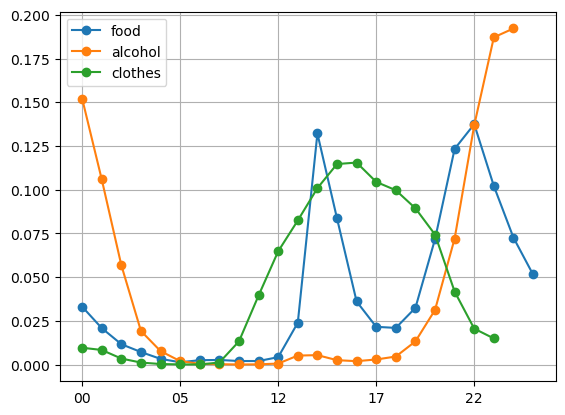

In [8]:
## 분석
df_target1 = df[df.type_of_business == "한식 음식점업"]
df_target2 = df[df.type_of_business == "기타 주점업"]
df_target3 = df[df.type_of_business == "의복 소매업"]

df_target1.transacted_time.str[:2].value_counts(normalize=True).sort_index().plot(marker="o")
df_target2.transacted_time.str[:2].value_counts(normalize=True).sort_index().plot(marker="o")
df_target3.transacted_time.str[:2].value_counts(normalize=True).sort_index().plot(marker="o")
plt.legend(["food", "alcohol", "clothes"])
plt.grid()
plt.show()

In [9]:
df = df.assign(transacted_hour = df.transacted_time.str[:2].astype(int))

In [10]:
df_tran_count = df.groupby(["store_id", "transacted_hour"]).size().reset_index(name="tran_count")

**ALS**
- PCA, SVD 둘 모두 행렬분해 알고리즘
- PCA는 정형 데이터의 차원축소에 주로 쓰인 반면
- SVD/ALS는 추천 모델에 활용
  - SVD: Singular Value Decomposition
  - ALS: Alternative Least Sqaure
  - BPR: Bayesian Personalized Ranking
  - NMF, ...
- ALS의 위상: 가성비 최고
  - PCA와 원리 자체는 비슷한데, 모델의 단순함과 성능에 있어서 어지간한 추천 알고리즘으로 이기기 쉽지 X
  - 단, PCA랑 목적 자체가 다르다보니, 직접적으로 비교되는 일은 X
- ALS로 하려는 것:
  - 상점 별로 각 시간대에 몇 회의 거래가 일어났는지
  - 이것을 압축할 것
  - 압축하지 않으면 ex)
    - 0시: 3회
    - 1시: 5회
    - 2시: 10회
    ....
    - 23시: 1회
    -> 총 24개의 변수
  - 3차원으로 압축하면 latent variable이 생성 ex)
    - x1: 2.7
    - x2: 9.1
    - x3: 0.3


In [11]:
import implicit
from scipy.sparse import coo_matrix

In [12]:
ALL_USERS = df_tran_count['store_id'].unique().tolist()
ALL_ITEMS = df_tran_count['transacted_hour'].unique().tolist()

user_ids = dict(list(enumerate(ALL_USERS)))
item_ids = dict(list(enumerate(ALL_ITEMS)))

user_map = {u: uidx for uidx, u in user_ids.items()}
item_map = {i: iidx for iidx, i in item_ids.items()}

df_tran_count['store_id_idx'] = df_tran_count['store_id'].map(user_map)
df_tran_count['transacted_hour_idx'] = df_tran_count['transacted_hour'].map(item_map)

In [13]:
row = df_tran_count['store_id_idx'].values
col = df_tran_count['transacted_hour_idx'].values
data = np.ones(df_tran_count.shape[0])
coo_train = coo_matrix((data, (row, col)), shape=(len(ALL_USERS), len(ALL_ITEMS)))
coo_train

<1966x24 sparse matrix of type '<class 'numpy.float64'>'
	with 27007 stored elements in COOrdinate format>

In [14]:
model = implicit.als.AlternatingLeastSquares(factors=5)

# train the model on a sparse matrix of user/item/confidence weights
model.fit(coo_train)

/Users/anchangbae/anaconda3/lib/python3.11/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 10 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()
/Users/anchangbae/anaconda3/lib/python3.11/site-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0007801055908203125 seconds
  warnings.warn(


  0%|          | 0/15 [00:00<?, ?it/s]

In [15]:
user_map_invese = {v:k for k, v in user_map.items()}

In [16]:
user_df = pd.DataFrame(model.user_factors)

In [17]:
user_df = user_df.reset_index()

In [18]:
user_df = user_df.assign(user_id_raw = user_df.index.map(user_map_invese))

In [19]:
model.similar_users(70)

(array([  70, 1165,  655,  427,  928,  602,  396, 1205, 1177,  641],
       dtype=int32),
 array([1.        , 0.99998647, 0.9992699 , 0.99925196, 0.9990886 ,
        0.9990886 , 0.9990886 , 0.9990885 , 0.99901617, 0.9988614 ],
       dtype=float32))

In [20]:
user_df[user_df["index"].isin([70, 1165])]

,index,0,1,2,3,4,user_id_raw
70,70,2.664954,1.301779,2.338583,2.610235,3.229681,77
1165,1165,2.691425,1.287321,2.359781,2.628293,3.270949,1256


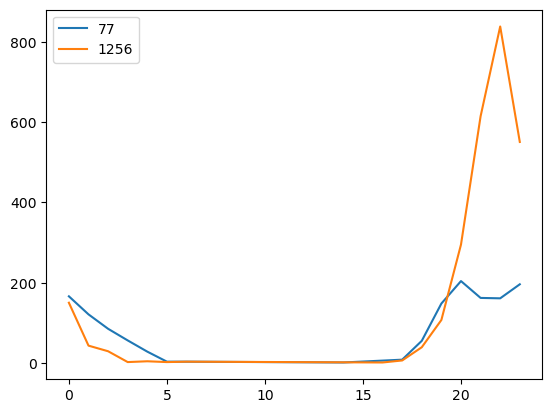

In [21]:
user_id1 = 77
user_id2 = 1256
df_target1 = df_tran_count[df_tran_count.store_id == user_id1]
df_target2 = df_tran_count[df_tran_count.store_id == user_id2]

plt.plot(df_target1.transacted_hour, df_target1.tran_count)
plt.plot(df_target2.transacted_hour, df_target2.tran_count)

plt.legend([user_id1, user_id2])
plt.show()

**Merging**

In [22]:
user_df = user_df.rename(columns={i:f"embed_{i}" for i in range(5)})
user_df = user_df.drop("index", axis=1)
user_df = user_df.rename(columns={"user_id_raw":"store_id"})

**표준화**

In [23]:
## 원본 데이터
df_feature_raw = pd.concat([daily_amount, store_card_count], axis=1)
df_feature_raw = df_feature_raw.merge(user_df, on="store_id", how="outer")

In [24]:
for i in range(5):
    target_variable = user_df[f"embed_{i}"]
    target_variable = (target_variable - target_variable.min()) / (target_variable.max() - target_variable.min())
    user_df[f"embed_{i}"] = target_variable

daily_amount = (daily_amount - daily_amount.min()) / (daily_amount.max() - daily_amount.min())
store_card_count = (store_card_count - store_card_count.min()) / (store_card_count.max() - store_card_count.min())

df_feature = pd.concat([daily_amount, store_card_count], axis=1)
df_feature = df_feature.merge(user_df, on="store_id", how="outer")


### K means

In [25]:
from sklearn.cluster import KMeans

In [49]:
kmeans = KMeans(n_clusters=5, random_state=0, n_init="auto").fit(df_feature.drop(["store_id", "amount"], axis=1))

In [50]:
df_feature_raw_kmeans = df_feature_raw.assign(cluster = kmeans.labels_)

<Axes: ylabel='cluster'>

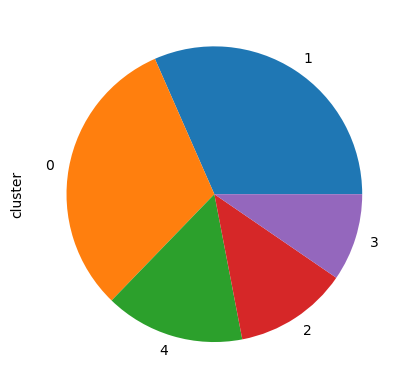

In [51]:
## 군집 크기 비교
df_feature_raw_kmeans.cluster.value_counts().plot.pie()

<Axes: xlabel='cluster'>

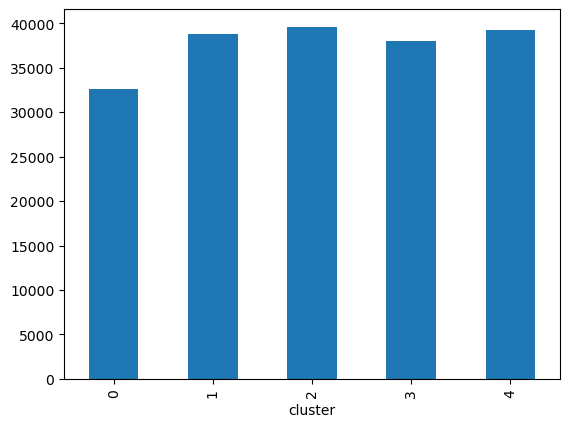

In [52]:
## 군집별 매출 차이
df_feature_raw_kmeans.groupby("cluster").amount.mean().plot.bar()

In [53]:
## 매출 합계
amount_total = df.groupby("store_id").amount.sum().reset_index(name="amount_total")

In [54]:
df_feature_raw_kmeans = df_feature_raw_kmeans.merge(amount_total, on="store_id", how="left")

In [55]:
with pd.option_context('display.float_format', '{:0.2f}'.format):
    display(df_feature_raw_kmeans.groupby("cluster").amount_total.median())

cluster
0    6886357.14
1    8776200.00
2   10868607.14
3   10107162.86
4   11453642.86
Name: amount_total, dtype: float64

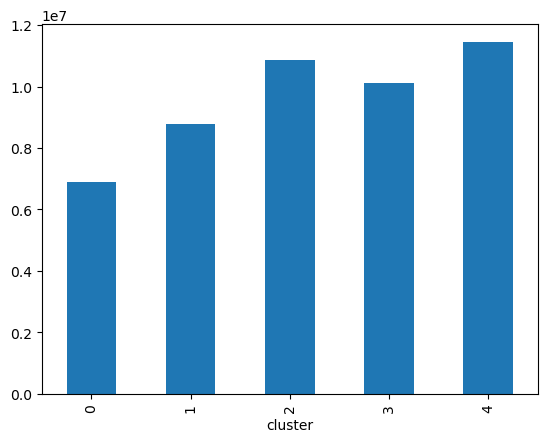

In [56]:
df_feature_raw_kmeans.groupby("cluster").amount_total.median().plot.bar()
plt.yscale("linear")
plt.show()

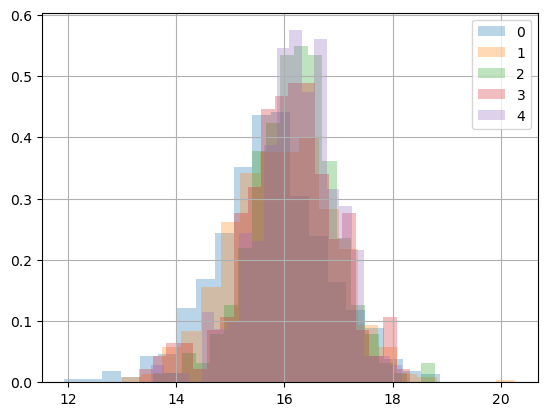

In [57]:
legs = []
for cluster, group in df_feature_raw_kmeans.groupby("cluster"):
    group.amount_total.apply(np.log).hist(alpha=0.3, density=True, bins=20)
    legs.append(cluster)
plt.legend(legs)
plt.show()

### GMM
- p=20
- n=1966

In [58]:
from sklearn.mixture import GaussianMixture

In [59]:
gmm = GaussianMixture(n_components=5, covariance_type='full').fit(df_feature)

In [60]:
labels = gmm.predict(df_feature)

In [61]:
df_feature_raw_gmm = df_feature_raw.assign(cluster = labels)

<Axes: ylabel='cluster'>

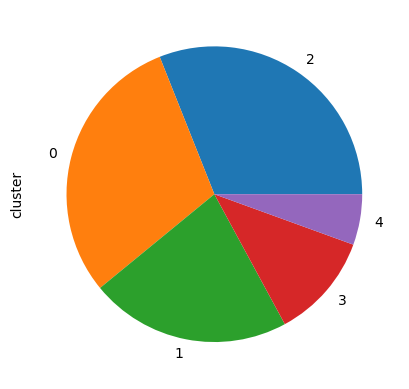

In [62]:
## 군집 크기 비교
df_feature_raw_gmm.cluster.value_counts().plot.pie()

<Axes: xlabel='cluster'>

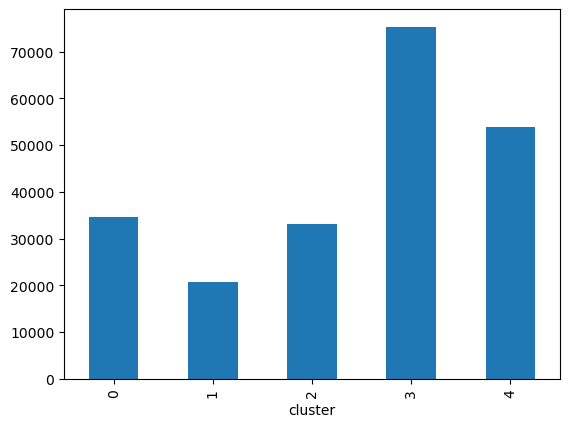

In [63]:
## 군집별 매출 차이
df_feature_raw_gmm.groupby("cluster").amount.mean().plot.bar()

In [64]:
df_feature_raw_gmm = df_feature_raw_gmm.merge(amount_total, on="store_id", how="left")

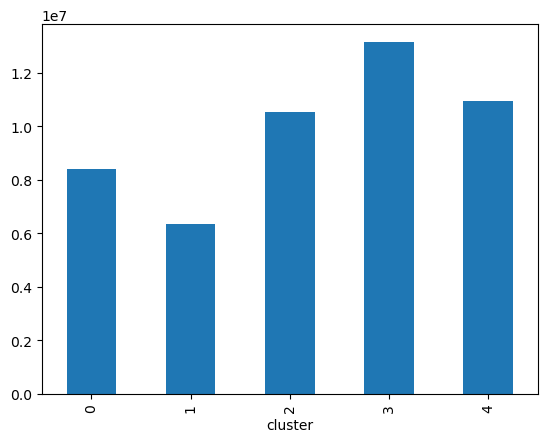

In [65]:
df_feature_raw_gmm.groupby("cluster").amount_total.median().plot.bar()
plt.yscale("linear")
plt.show()

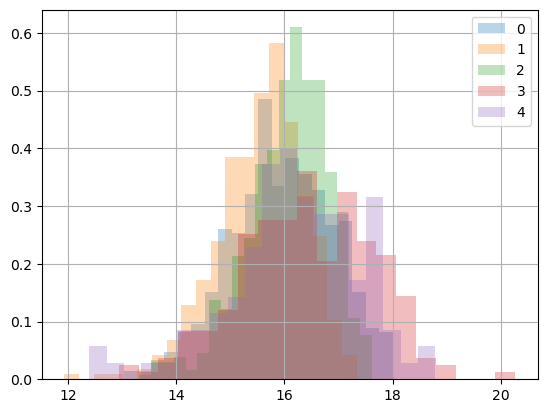

In [66]:
legs = []
for cluster, group in df_feature_raw_gmm.groupby("cluster"):
    group.amount_total.apply(np.log).hist(alpha=0.3, density=True, bins=20)
    legs.append(cluster)
plt.legend(legs)
plt.show()

In [67]:
df_feature_raw_gmm = df_feature_raw_gmm.assign(
    amount_total_log = df_feature_raw_gmm.amount_total.apply(np.log)
)

In [68]:
import scipy.stats as stats

F, p_value = stats.f_oneway(*[group.amount_total_log for dow, group in df_feature_raw_gmm.groupby('cluster')])
print(f"F statistics: {F:.4f}")
print(f"P-value: {p_value:.4f}")

F statistics: 38.6613
P-value: 0.0000


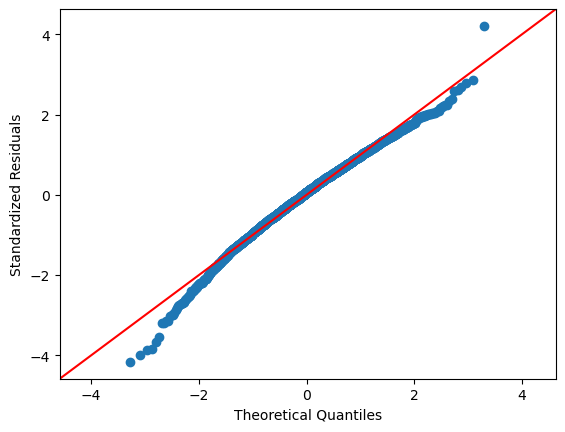

Normaility test p-value: 0.0000
Equal variance test p-value: 0.0000
Independence test statistic: 1.9592


In [69]:
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson

df_feature_raw_gmm['residual'] = (
    df_feature_raw_gmm['amount_total_log'] - 
    df_feature_raw_gmm.groupby('cluster').amount_total_log.transform('mean')
)

df_feature_raw_gmm['std_resi'] = (
    (df_feature_raw_gmm['residual'] - df_feature_raw_gmm['residual'].mean()) / 
    df_feature_raw_gmm['residual'].std()
)
# df_feature_raw_gmm = df_feature_raw_gmm.assign(push_count_ma = df_feature_raw_gmm.push_count.rolling(28).mean())


# QQ plot
sm.qqplot(df_feature_raw_gmm['std_resi'], line='45')
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Standardized Residuals")
plt.show()

# normality
w, pvalue = stats.shapiro(df_feature_raw_gmm.residual)
print(f"Normaility test p-value: {pvalue:.4f}")

# equal variance
w, pvalue = stats.bartlett(*[group.residual for dow, group in df_feature_raw_gmm.groupby('cluster')])
print(f"Equal variance test p-value: {pvalue:.4f}")

# independency
d = durbin_watson(df_feature_raw_gmm.residual)
print(f"Independence test statistic: {d:.4f}")